In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [6]:
""" The following codes show how to get stock data from yfinance and then compute well known technical indicators:
I will periodically add more indicators.

*) RSI - Relative Strength Index.
*) MFI - Money Flow Index. 
*) MACD - Moving Average Convergence Divergence.
*) Aroon Indicators.
*) Average Directional Index."""

' The following codes show how to get stock data from yfinance and then compute well known technical indicators:\nI will periodically add more indicators.\n\n RSI - Relative Strength Index.\n MFI - Money Flow Index. \n MACD - Moving Average Convergence Divergence.\n Aroon Indicators.'

### Get Stock Data

In [23]:
ticker = 'JUN3.F' ### stock ticker
#ticker = 'JEN.F'
#ticker = '4A3.F'

data = []
data = yf.download(ticker, start='2024-01-01', end='2025-02-14', progress=False)
data = data[['Close','High','Low', 'Volume']] ### To compute RSI and MFI we only need these quantities

### Fill Forward -- Weekends and periods where the market ist not operating, for example weekends.
idx = pd.date_range(data.index[0], data.index[-1])
data = data.reindex(idx)
data.ffill(inplace=True)

data.head()

,Close,High,Low,Volume
2024-01-02,32.799999,33.419998,32.799999,60.0
2024-01-03,31.340000,33.240002,31.320000,459.0
2024-01-04,31.719999,31.719999,31.719999,0.0
2024-01-05,30.820000,31.180000,30.820000,3.0
2024-01-06,30.820000,31.180000,30.820000,3.0


### RSI - Relative Strength Index

In [24]:
### RSI - Relative Strength Index

### References
### https://wire.insiderfinance.io/calculate-rsi-with-python-and-yahoo-finance-c8fb78b1c199

window = 14 ### how many past days to consider in the exponentially weighted calculations.
adjust = False

delta = []
delta = data['Close'].diff(1) ### compute the price difference

loss = delta.copy()
gains = delta.copy()

gains[gains < 0] = 0
loss[loss > 0] = 0

gain_ewm = gains.ewm(com=window - 1, adjust=adjust).mean()
loss_ewm = abs(loss.ewm(com=window - 1, adjust=adjust).mean())

RS = []
RS = gain_ewm / loss_ewm

RSI = []
RSI = 100 - 100 / (1 + RS)
data['RSI'] = pd.DataFrame(RSI).rename(columns={"Close": "RSI"})

data.tail()

,Close,High,Low,Volume,RSI
2025-02-09,24.260000,24.260000,24.080000,250.0,46.763574
2025-02-10,25.080000,25.080000,24.440001,225.0,54.389537
2025-02-11,24.780001,24.780001,24.780001,0.0,51.483856
2025-02-12,25.440001,25.440001,24.980000,78.0,56.934753
2025-02-13,26.680000,26.680000,25.260000,1560.0,64.911248


### MFI - Money Flow Index

In [27]:
### References
### https://www.investopedia.com/terms/m/mfi.asp
### https://en.wikipedia.org/wiki/Money_flow_index

### Calculate the typical price and money flow

typical_price = []
typical_price  = data[['Close', 'High', 'Low']].sum(axis=1)/3 ### (Close + High + Low)/3

money_flow = []
money_flow = typical_price * data['Volume']

### For each period, mark whether the typical price was higher or lower than the prior period. 
### This will tell you whether raw money flow is positive or negative.

### Positive money flow is calculated by adding the money flow of all the 
### days where the typical price is higher than the previous day's typical price.

positive_flow = []
negative_flow = []

# Loop through the typical price
for i in range(0, len(typical_price)):

    if i == 0: ### money flow is not defined (there is no "previous typical price")
        positive_flow.append(0)
        negative_flow.append(0)

    else:
        if typical_price[i] > typical_price[i-1]:
            positive_flow.append(money_flow[i])
            negative_flow.append(0)

        elif typical_price[i] < typical_price[i-1]:
            negative_flow.append(money_flow[i])
            positive_flow.append(0)

        else:
            positive_flow.append(0)
            negative_flow.append(0)

positive_flow = pd.Series(positive_flow)
negative_flow = pd.Series(negative_flow)

# Get all of the positive and negative money flows within the time period

positive_mf = []
negative_mf = []

positive_mf = positive_flow.ewm(com=window - 1, adjust=adjust).mean()
negative_mf = negative_flow.ewm(com=window - 1, adjust=adjust).mean()

# Calculate the money flow index

MFI = []
MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
MFI = pd.DataFrame(MFI, columns=['MFI'])
MFI.set_index([data.index],inplace=True)

data['MFI'] = MFI

data.head()

C:\Users\celes\AppData\Local\Temp\ipykernel_12644\1634384475.py:56: RuntimeWarning: invalid value encountered in divide
  MFI = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))


,Close,High,Low,Volume,RSI,MFI
2024-01-02,32.799999,33.419998,32.799999,60.0,NaN,NaN
2024-01-03,31.340000,33.240002,31.320000,459.0,0.000000,0.0
2024-01-04,31.719999,31.719999,31.719999,0.0,1.962807,0.0
2024-01-05,30.820000,31.180000,30.820000,3.0,1.869227,0.0
2024-01-06,30.820000,31.180000,30.820000,3.0,1.869227,0.0


### Plot Output RSI und MFI

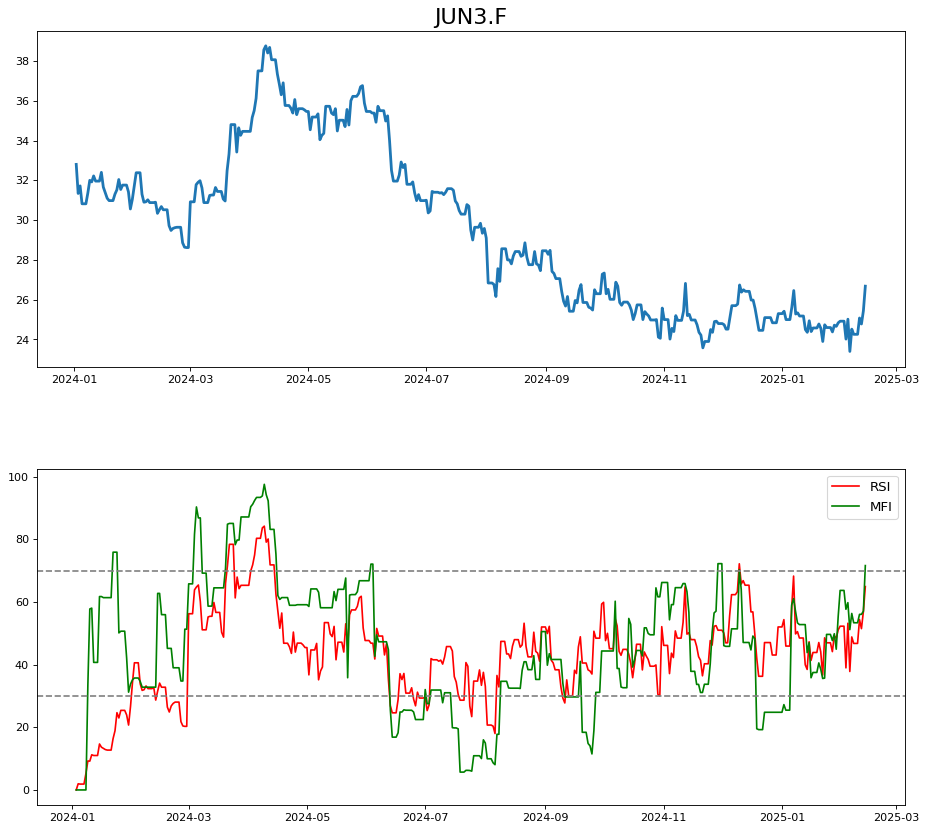

In [28]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['RSI'], color='red', linewidth=1.5)
ax2.plot(data['MFI'], color='green', linewidth=1.5)
ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['RSI', 'MFI'], fontsize=12)

plt.show()

 ## MACD - Moving Average Convergence Divergence

In [22]:
### References
### https://medium.com/@financial_python/building-a-macd-indicator-in-python-190b2a4c1777
### https://medium.com/@teopan00/macd-indicator-for-algorithmic-trading-in-python-ce2833993550

In [29]:
# Calculate the 12-period EMA
ema12 = []
ema12 = data['Close'].ewm(span=12, adjust=False).mean()

# Calculate the 26-period EMA
ema26 = []
ema26 = data['Close'].ewm(span=26, adjust=False).mean()

# Calculate MACD (the difference between 12-period EMA and 26-period EMA)
# Typically, widely-accepted values for the fast and slow lengths are 12 and 26, respectively. 
# The final values of the MACD line are determined by subtracting the EMA with the slow length from 
# the EMA with the fast length.

macd = []
macd = ema12 - ema26 ### fast - slow

# Calculate the 9-period EMA of MACD (Signal Line)
# The commonly used period for computing the Signal line is 9. 
# Since the Signal line averages out the MACD line, it tends to offer a smoother representation of trends.

signal_line = []
signal_line = macd.ewm(span=9, adjust=False).mean()

### Add MACD and Signal_line to dataframe

macd = pd.DataFrame(macd).rename(columns={"Close": "MACD"})
macd.set_index([data.index],inplace=True)

signal_line = pd.DataFrame(signal_line).rename(columns={"Close": "Signal_Line"})
signal_line.set_index([data.index],inplace=True)

# If MACD is above the signal line, the histogram will be above the MACD’s baseline or zero line. 
# If MACD is below its signal line, the histogram will be below the MACD’s baseline. 
# Traders use the MACD’s histogram to identify peaks of bullish or bearish momentum, 
# and to generate overbought/oversold trade signals.

data['MACD'] = macd
data['Signal_Line'] = signal_line

data.tail()

,Close,High,Low,Volume,RSI,MFI,MACD,Signal_Line
2025-02-09,24.260000,24.260000,24.080000,250.0,46.763574,53.361641,-0.159935,-0.135404
2025-02-10,25.080000,25.080000,24.440001,225.0,54.389537,56.044351,-0.094468,-0.127217
2025-02-11,24.780001,24.780001,24.780001,0.0,51.483856,56.044351,-0.066032,-0.114980
2025-02-12,25.440001,25.440001,24.980000,78.0,56.934753,57.054315,0.009649,-0.090054
2025-02-13,26.680000,26.680000,25.260000,1560.0,64.911248,71.613511,0.167751,-0.038493


### Plot MACD

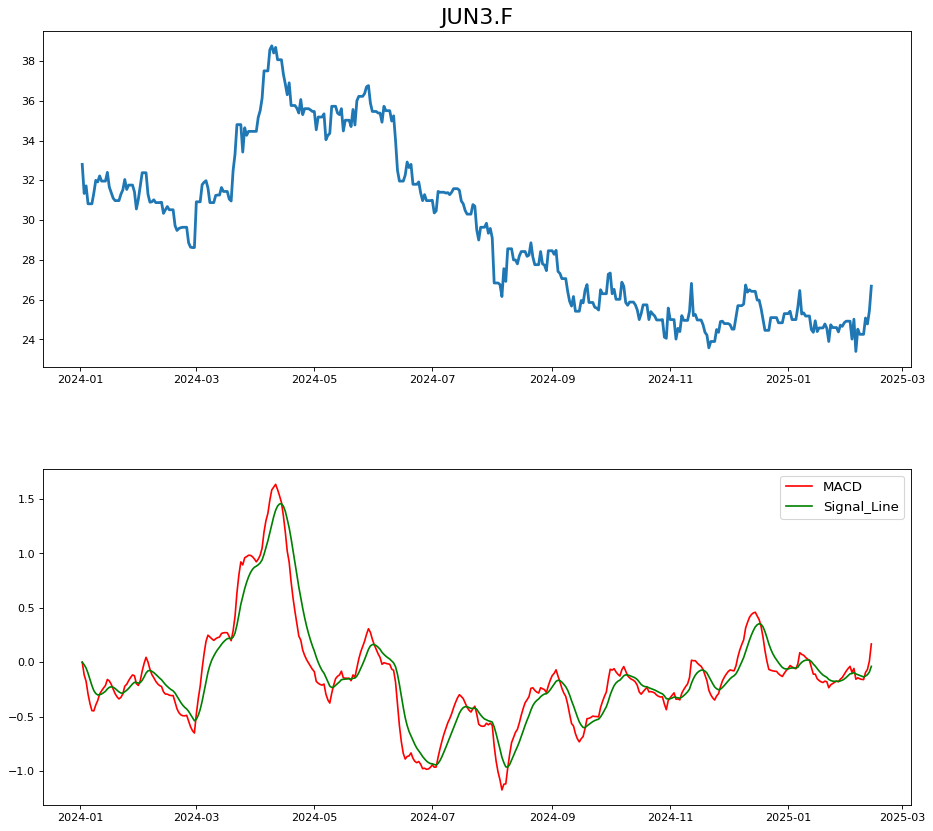

In [30]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['MACD'], color='red', linewidth=1.5)
ax2.plot(data['Signal_Line'], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['MACD', 'Signal_Line'], fontsize=12)

plt.show()

### Aroon Indicators

In [31]:
### References
### https://medium.com/@jasperc09/a-complete-guide-implementing-aroon-indicators-using-python-1fe79e4bede6

In [32]:
period = 25 ### typical period

#Aroon Up and Down Formulas 
data['aroon_up'] = 100 * data.High.rolling(period).apply(lambda x: x.argmax()) / (period)
data['aroon_down'] = 100 * data.Low.rolling(period).apply(lambda x: x.argmin()) / (period)
data.head()

,Close,High,Low,Volume,RSI,MFI,MACD,Signal_Line,aroon_up,aroon_down
2024-01-02,32.799999,33.419998,32.799999,60.0,NaN,NaN,0.000000,0.000000,NaN,NaN
2024-01-03,31.340000,33.240002,31.320000,459.0,0.000000,0.0,-0.116467,-0.023293,NaN,NaN
2024-01-04,31.719999,31.719999,31.719999,0.0,1.962807,0.0,-0.176076,-0.053850,NaN,NaN
2024-01-05,30.820000,31.180000,30.820000,3.0,1.869227,0.0,-0.292566,-0.101593,NaN,NaN
2024-01-06,30.820000,31.180000,30.820000,3.0,1.869227,0.0,-0.380499,-0.157374,NaN,NaN


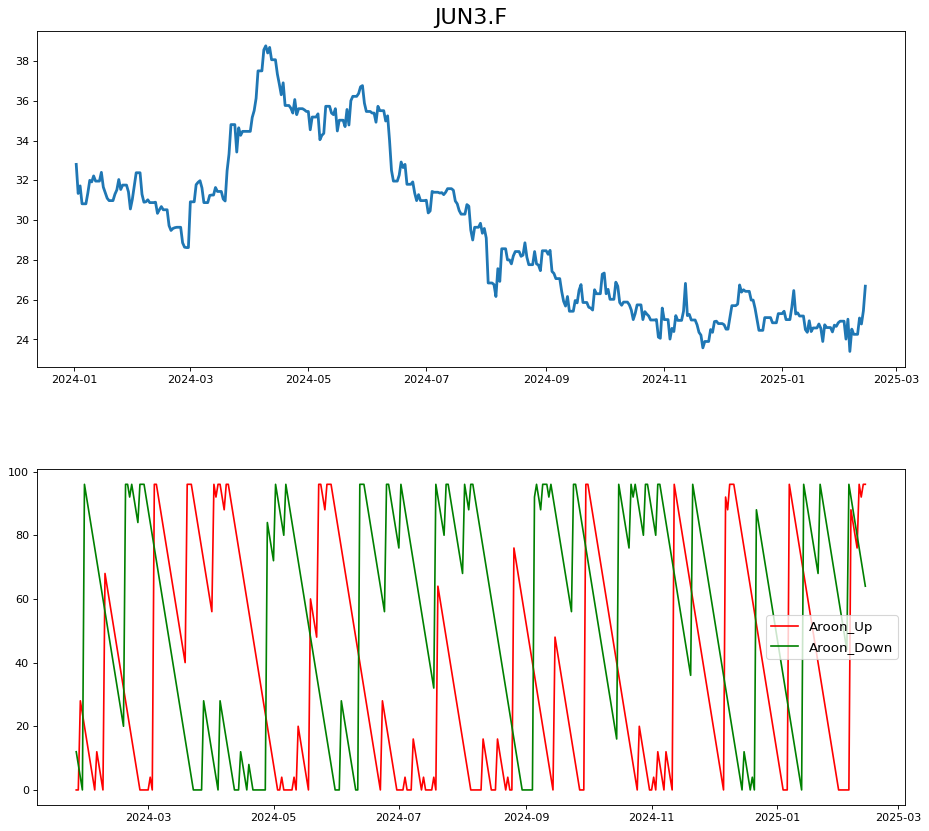

In [33]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['aroon_up'], color='red', linewidth=1.5)
ax2.plot(data['aroon_down'], color='green', linewidth=1.5)
#ax2.axhline(30, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['Aroon_Up', 'Aroon_Down'], fontsize=12)

plt.show()

### Average Directional Index

In [34]:
#### References
#### https://eodhd.medium.com/algorithmic-trading-with-the-average-directional-index-in-python-6f3b2ce08e75
#### https://www.investopedia.com/top-7-technical-analysis-tools-4773275

### ADX above 20 and DI+ above DI-. That's an uptrend.
### ADX above 20 and DI- above DI+. That's a downtrend.
### ADX below 20 is a weak trend or ranging period, often associated with the DI- and DI+ 
### rapidly crisscrossing each other.

In [35]:
period = 14

plus_dm = data.High.diff()
minus_dm = data.Low.diff()

plus_dm[plus_dm < 0] = 0
minus_dm[minus_dm > 0] = 0
    
tr1 = pd.DataFrame(data.High - data.Low)
tr2 = pd.DataFrame(abs(data.High - data.Close.shift(1)))
tr3 = pd.DataFrame(abs(data.Low - data.Close.shift(1)))

frames = [tr1, tr2, tr3]

tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
atr = tr.rolling(period).mean()
    
plus_di = 100 * (plus_dm.ewm(alpha = 1/period).mean() / atr)
minus_di = abs(100 * (minus_dm.ewm(alpha = 1/period).mean() / atr))
dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
adx = ((dx.shift(1) * (period - 1)) + dx) / period
adx_smooth = adx.ewm(alpha = 1/period).mean()

data['plus_di'] = pd.DataFrame(plus_di).rename(columns = {0:'plus_di'})
data['minus_di'] = pd.DataFrame(minus_di).rename(columns = {0:'minus_di'})
data['adx'] = pd.DataFrame(adx).rename(columns = {0:'adx'})

data.tail()

,Close,High,Low,Volume,RSI,MFI,MACD,Signal_Line,aroon_up,aroon_down,plus_di,minus_di,adx
2025-02-09,24.260000,24.260000,24.080000,250.0,46.763574,53.361641,-0.159935,-0.135404,76.0,80.0,18.085643,24.734251,15.526913
2025-02-10,25.080000,25.080000,24.440001,225.0,54.389537,56.044351,-0.094468,-0.127217,96.0,76.0,27.026020,22.244133,15.111093
2025-02-11,24.780001,24.780001,24.780001,0.0,51.483856,56.044351,-0.066032,-0.114980,92.0,72.0,25.228024,20.764268,9.705444
2025-02-12,25.440001,25.440001,24.980000,78.0,56.934753,57.054315,0.009649,-0.090054,96.0,68.0,30.676222,18.406898,10.797700
2025-02-13,26.680000,26.680000,25.260000,1560.0,64.911248,71.613511,0.167751,-0.038493,96.0,64.0,38.228317,14.815660,26.364259


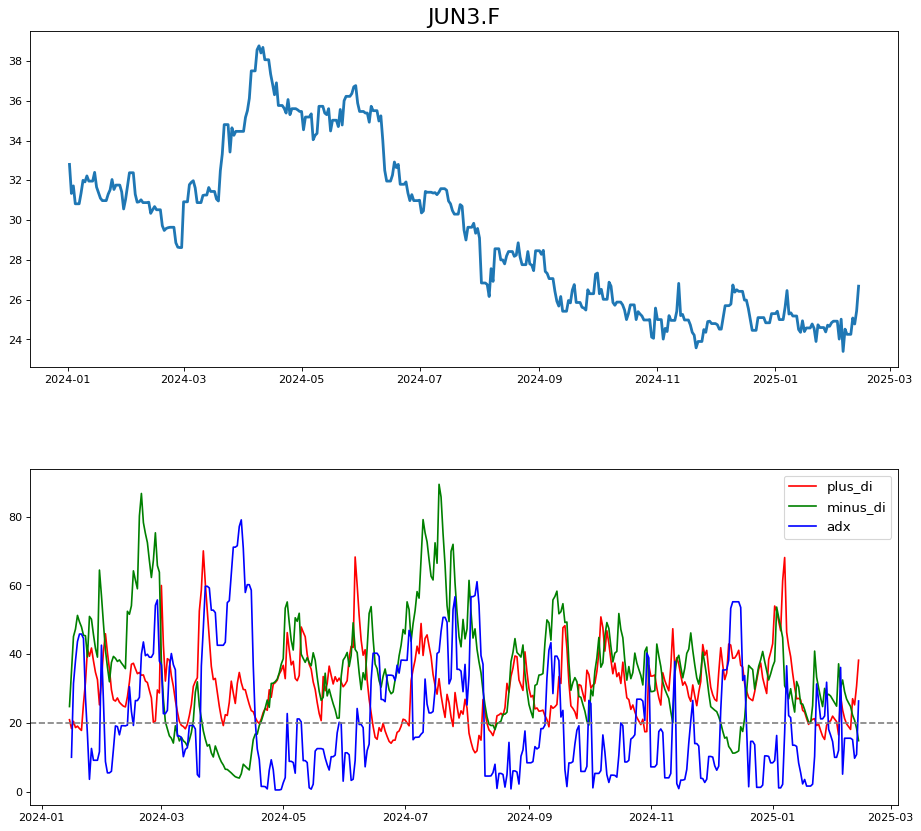

In [14]:
figure(figsize=(14, 14), dpi=80)

ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1)
ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=4, colspan=1)
ax1.plot(data['Close'], linewidth=2.5)
ax1.set_title(ticker, fontsize=20)
ax2.plot(data['plus_di'], color='red', linewidth=1.5)
ax2.plot(data['minus_di'], color='green', linewidth=1.5)
ax2.plot(data['adx'], color='blue', linewidth=1.5)
ax2.axhline(20, linestyle='--', linewidth=1.5, color='grey')
#ax2.axhline(70, linestyle='--', linewidth=1.5, color='grey')
ax2.legend(['plus_di', 'minus_di', 'adx'], fontsize=12)

plt.show()